[*********************100%***********************]  10 of 10 completed
/var/folders/2x/fl41g3y53gq2fk746q87y9mm0000gn/T/ipykernel_81336/1768564173.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_ends = px.resample("M").last().index
/var/folders/2x/fl41g3y53gq2fk746q87y9mm0000gn/T/ipykernel_81336/1768564173.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret_m = px.resample("M").last().pct_change().shift(-1)  # forward returns for portfolio PnL


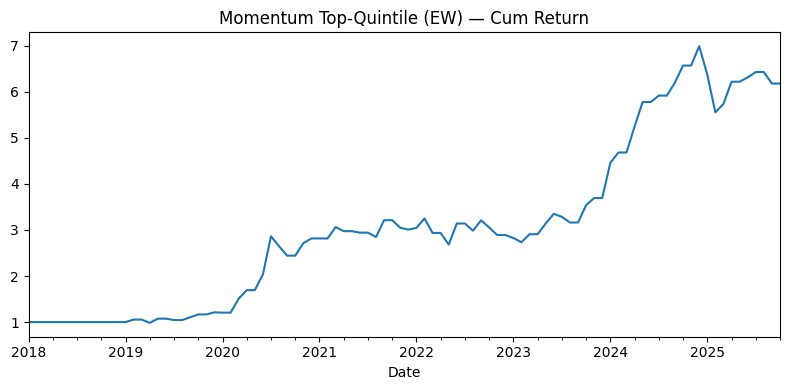

Annualized Sharpe: 1.01 Max DD: -0.21


In [ ]:
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","JPM","XOM","UNH"]
px = yf.download(tickers, start="2018-01-01", auto_adjust=True)["Close"]
ret_d = px.pct_change()
px.tail(), ret_d.tail()

# 12-month momentum excluding most recent month (12-1)
mom = px.pct_change(252).shift(21)

# Month-end rebalance dates and next-month returns
m_ends = px.resample("M").last().index
mom_m = mom.reindex(m_ends).dropna(how="all")
ret_m = px.resample("M").last().pct_change().shift(-1)  # forward returns for portfolio PnL

def top_quantile_weights(factor_df, q=0.2):
    ranks = factor_df.rank(axis=1, pct=True)
    long = (ranks >= 1 - q).astype(float)
    return long.div(long.sum(axis=1), axis=0).fillna(0.0)  # EW within selection

w = top_quantile_weights(mom_m, q=0.2)
port_ret = (w * ret_m).sum(axis=1).dropna()
port_cum = (1 + port_ret).cumprod()

fig, ax = plt.subplots(figsize=(8,4))
port_cum.plot(ax=ax, title="Momentum Top-Quintile (EW) — Cum Return")
fig.tight_layout()
fig.savefig("../results/mom_top_quintile_cum.png", dpi=150)
plt.show()

sharpe = (port_ret.mean() / port_ret.std()) * (12 ** 0.5)
max_dd = (port_cum / port_cum.cummax() - 1).min()
print("Annualized Sharpe:", round(sharpe,2), "Max DD:", round(max_dd,2))



In [4]:
import sys, os
sys.path.append(os.path.join("..", "src"))
from costs import compute_turnover, apply_costs


Gross Sharpe: 1.01
Net Sharpe: 0.98
Net Max DD: -0.21


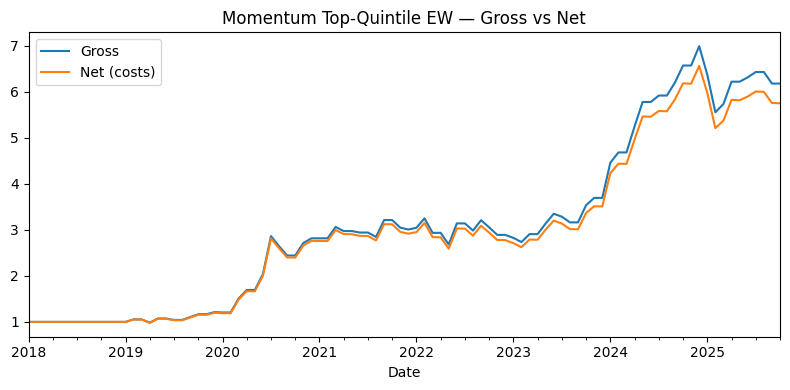

In [6]:
cost_per_turn = 0.0025
w_monthly = w.reindex(ret_m.index).fillna(0.0)
gross_port_ret = (w_monthly * ret_m).sum(axis=1).dropna()

gross2, costs, net_port_ret = apply_costs(gross_port_ret, w, cost_per_turn)

import numpy as np
assert np.allclose(gross_port_ret.loc[gross2.index].values, gross2.values, atol=1e-12)

gross_cum = (1 + gross2).cumprod()
net_cum = (1 + net_port_ret).cumprod()

def ann_sharpe(x):
    return (x.mean() / x.std()) * (12 ** 0.5)

print("Gross Sharpe:", round(ann_sharpe(gross2), 2))
print("Net Sharpe:", round(ann_sharpe(net_port_ret), 2))
print("Net Max DD:", round((net_cum / net_cum.cummax() - 1).min(), 2))

fig, ax = plt.subplots(figsize=(8,4))
gross_cum.plot(ax=ax, label="Gross")
net_cum.plot(ax=ax, label="Net (costs)")
ax.set_title("Momentum Top-Quintile EW — Gross vs Net")
ax.legend()
fig.tight_layout()
fig.savefig("../results/mom_top_quintile_gross_vs_net.png", dpi=150)
plt.show()


In [7]:
# Export all key artifacts to results/
gross2.to_csv("../results/mom_topq_gross_monthly.csv", header=True)
net_port_ret.to_csv("../results/mom_topq_net_monthly.csv", header=True)
costs.to_csv("../results/mom_topq_costs.csv", header=True)

# also export weights (rows = rebalance dates, cols = tickers)
w.to_csv("../results/mom_topq_weights.csv")

print("Exported:")
print("  - mom_topq_gross_monthly.csv")
print("  - mom_topq_net_monthly.csv")
print("  - mom_topq_costs.csv")
print("  - mom_topq_weights.csv")


Exported:
  - mom_topq_gross_monthly.csv
  - mom_topq_net_monthly.csv
  - mom_topq_costs.csv
  - mom_topq_weights.csv
